<a href="https://colab.research.google.com/github/SimantaKarki/Python/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
specific_wc = ['br', 'movie', 'film']
sw = list(set(stopwords.words('english')))
sw = sw + specific_wc

print(sw[:5])
print(len(sw))

['where', 'but', 'isn', 'for', 'between']
182


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

In [ ]:
#Preprocessing Data
# containers for features and labels
labels = []

sentences = []
for ind, row in df.iterrows():
    labels.append(row['sentiment'])
    sentence = row['review']
    for word in sw: # removing stop words
        token = " "+word+" "
        sentence = sentence.replace(token, " ") # replacing stop words with space
        sentence = sentence.replace(" ", " ")
    sentences.append(sentence)
    
# label encoding labels 
enc = LabelEncoder()
encoded_labels = enc.fit_transform(labels)

print(enc.classes_)
print(labels[:5])
print(encoded_labels[:5])

['negative' 'positive']
['positive', 'positive', 'positive', 'negative', 'positive']
[1 1 1 0 1]


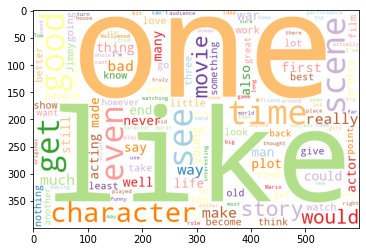

In [ ]:
# word cloud on entire reviews
wc = WordCloud(width = 600, height = 400, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10, colormap='Paired_r').generate(' '.join(sentences[:100]))
plt.imshow(wc)

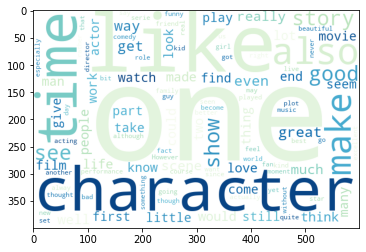

In [ ]:
# word cloud on positve reviews
pos_rev = ' '.join(df[df['sentiment']=='positive']['review'].to_list()[:10000])
wc = WordCloud(width = 600, height = 400, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10, colormap='GnBu').generate(pos_rev)
plt.imshow(wc)

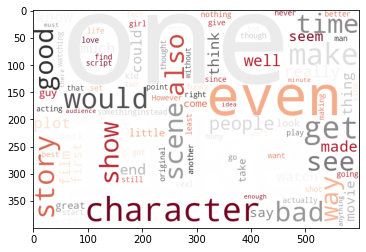

In [ ]:
# word cloud on positve reviews
neg_rev = ' '.join(df[df['sentiment']=='negative']['review'].to_list()[:10000])
wc = WordCloud(width = 600, height = 400, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10, colormap='RdGy').generate(neg_rev)
plt.imshow(wc)

In [ ]:
#Train Test Split
# model parameters
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .7

In [ ]:
# train test split
# ---------------

# proportion of training dataset
train_size = int(len(sentences) * training_portion)

# training dataset
train_sentences = sentences[:train_size]
train_labels = encoded_labels[:train_size]

# validation dataset
validation_sentences = sentences[train_size:]
validation_labels = encoded_labels[train_size:]

In [ ]:
# tokenizing, sequencing, padding features

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
print(train_padded.shape)
print(validation_padded.shape)
print(train_labels.shape)
print(validation_labels.shape)

(35000, 120)
(15000, 120)
(35000,)
(15000,)


In [ ]:
#With Word Embedding
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
num_epochs = 10
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_data=(validation_padded, validation_labels))

Epoch 1/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1486 - accuracy: 0.9469 - val_loss: 0.6845 - val_accuracy: 0.8065
Epoch 2/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1476 - accuracy: 0.9468 - val_loss: 0.6830 - val_accuracy: 0.8056
Epoch 3/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1468 - accuracy: 0.9483 - val_loss: 0.6923 - val_accuracy: 0.8062
Epoch 4/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1460 - accuracy: 0.9468 - val_loss: 0.6888 - val_accuracy: 0.8035
Epoch 5/10
1094/1094 [==============================] - 7s 7ms/step - loss: 0.1457 - accuracy: 0.9481 - val_loss: 0.6989 - val_accuracy: 0.8061
Epoch 6/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1450 - accuracy: 0.9479 - val_loss: 0.7086 - val_accuracy: 0.8131
Epoch 7/10
1094/1094 [==============================] - 7s 6ms/step - loss: 0.1444 - accuracy: 0.9485 - val_loss: 0.7030 - val_accuracy:

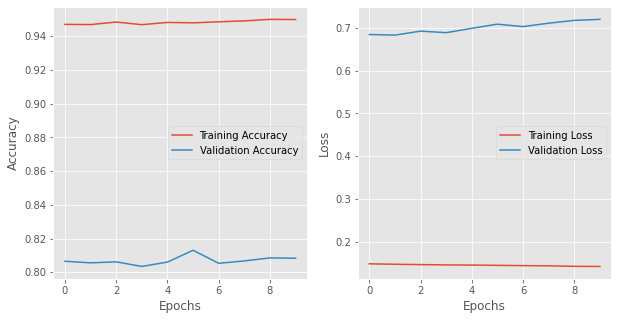

In [ ]:
# loss and accuracy

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.style.use("ggplot")
plt.show()

In [ ]:
my_text = 'you are a bad'

seq = tokenizer.texts_to_sequences([my_text])
print('raw seq:',seq)
seq = pad_sequences(seq, maxlen=max_length)
print('padded seq:',seq)
prediction = model.predict(seq)
print('positivity:',prediction)

raw seq: [[68, 595, 31, 21]]
padded seq: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0  68 595  31  21]]
positivity: [[0.6749819]]


In [ ]:
#With LSTM
# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model fit
num_epochs = 20
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_data=(validation_padded, validation_labels))

Epoch 1/20
1094/1094 [==============================] - 63s 50ms/step - loss: 0.4191 - accuracy: 0.8000 - val_loss: 0.3582 - val_accuracy: 0.8456
Epoch 2/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.3409 - accuracy: 0.8522 - val_loss: 0.3551 - val_accuracy: 0.8448
Epoch 3/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.3298 - accuracy: 0.8597 - val_loss: 0.3464 - val_accuracy: 0.8519
Epoch 4/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.3149 - accuracy: 0.8650 - val_loss: 0.3327 - val_accuracy: 0.8563
Epoch 5/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.3027 - accuracy: 0.8695 - val_loss: 0.3396 - val_accuracy: 0.8489
Epoch 6/20
1094/1094 [==============================] - 53s 49ms/step - loss: 0.2914 - accuracy: 0.8764 - val_loss: 0.3344 - val_accuracy: 0.8486
Epoch 7/20
1094/1094 [==============================] - 54s 49ms/step - loss: 0.2814 - accuracy: 0.8821 - val_loss: 0.3470 -

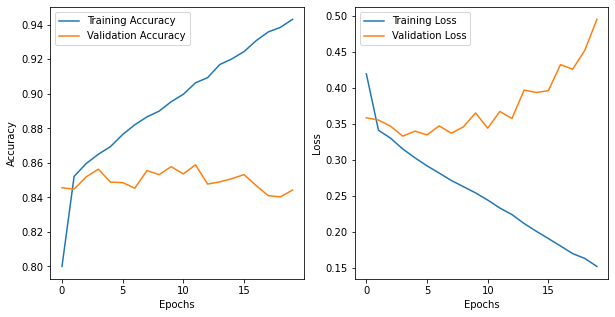

In [ ]:
# accuracy and loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
my_text = 'This is good.'

seq = tokenizer.texts_to_sequences([my_text])
print('raw seq:',seq)
seq = pad_sequences(seq, maxlen=max_length)
print('padded seq:',seq)
prediction = model.predict(seq)
print('positivity:',prediction)

raw seq: [[8, 77, 9]]
padded seq: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8 77  9]]
positivity: [[0.21234067]]
